In [1]:

import os
import matplotlib.pyplot as plt
%matplotlib inline
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
# from pyvirtualdisplay import Display

from gym import wrappers
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers,models
import os
from tensorflow.keras import backend as K
%matplotlib inline
tf.config.experimental_run_functions_eagerly(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
# strategy = tf.distribute.MirroredStrategy()

print("*****************")
print(gpus)
print("*****************")

import matplotlib.animation as animation

*****************
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
*****************


In [4]:
MEMORYLEN=int(1e5)
MEMORYLEN=int(10000)
BATCHSIZE=64
EPOCHS=1
# UPDATE_EVERY = 4


class DQNAgent():
    def __init__(self,actions=2,obs=4):
        self.actions=actions
        self.observations=obs
        self.model=self.load_model()
        self.target_model=self.load_model()
        
        self.copy_weights()

        self.memory=deque(maxlen=MEMORYLEN)
        self.gamma=0.99
        self.patience=0
        
           
    def play(self,observation,epsilon):
        if (len(self.memory)<BATCHSIZE):
            
            action=np.random.randint(low=0,high=self.actions)
            return action
        else:
            if np.random.random()>epsilon:
#                 print("model")
                action=self.model_predictions(observation)
            else:
                action=np.random.randint(low=0,high=self.actions)
            return action
            
    def step(self,state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
        if ((len(self.memory)>=BATCHSIZE) ):
            self.train_model()
        pass
 
    
    def train_model(self):
        
        rnd_indices = np.random.choice(len(self.memory), size=BATCHSIZE)
        data=np.array(self.memory)[rnd_indices]
        np.random.shuffle(data)
        
        state, action, reward, next_state, done=np.stack(data[:,0]),np.stack(data[:,1]),np.stack(data[:,2]),np.stack(data[:,3]),np.stack(data[:,4])
        qnext_max=np.max(self.target_model.predict(next_state),axis=1)
        qnext_max=reward+ self.gamma*qnext_max*(1-done)
        qtable_to_update=self.target_model.predict(state)
        for indx,qs in enumerate(qtable_to_update):
            qtable_to_update[indx,action[indx]]=qnext_max[indx]
        self.model.fit(state,qtable_to_update,epochs=1,verbose=0)
        self.patience+=1
        if self.patience==10:
            self.copy_weights()
            self.patience=0
        
        pass
    def model_predictions(self,observation):
        pred=self.model.predict(observation.reshape(1,-1))
        pred=np.argmax(pred)
        return pred
        
    def load_model(self):
        num_input = layers.Input(shape=(self.observations, ))
        x = layers.Dense(64,activation="relu")(num_input)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.1)(x)
        x = layers.Dense(32, activation="relu")(x)
#         x = layers.Dropout(0.1)(x)
#         x = layers.BatchNormalization()(x)
        y = layers.Dense(self.actions, activation="linear")(x)
        model = models.Model(inputs=num_input, outputs=y)
        model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(lr=0.001,decay=0.001))
        model.summary()
        return model
    def copy_weights(self):
        self.target_model.set_weights(self.model.get_weights()) 

In [5]:
import matplotlib.animation as animation
# import matplotlib.pyplot as plt
# %matplotlib inline
def gen_gif(agent,fname):
    env = gym.make('CartPole-v0')
    # env = gym.wrappers.Monitor(env,"/anotherdrive/projects/gym/lunar/notefiles/test",force=True)
    action_space = env.action_space.n
    observation_space = env.observation_space.shape[0]

    scores = []

    rewards=[]

    state = env.reset()
    cum_reward = 0
    frames = []
    fig = plt.figure()
  
    while True:
        f=plt.imshow(env.render(mode = 'rgb_array'),animated=True)
        frames.append([f])

    #         q_values = agent.get_q(obs)
        action = agent.play(state,0)

        obs, reward, done, _ = env.step(action)
    #             print(t,action,reward)
        cum_reward += reward
    #     print(reward)
        rewards.append(reward)
    #     print(done)
        if done:
            break
    scores.append(cum_reward)
    env.close()
    print(cum_reward)    
#     ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True,
#                                 repeat_delay=0)

#     ani.save('/anotherdrive/projects/gym/lunar/dqnote/gifs/lunar_{}_.gif'.format(fname),writer="PillowWriter")
    plt.close()
#     plt.show()

In [6]:
# import os
# os.getcwd()

new best_score: 200.0
9.0

Environment solved in -99 episodes!	Average Score: 200.00
25.434303998947144


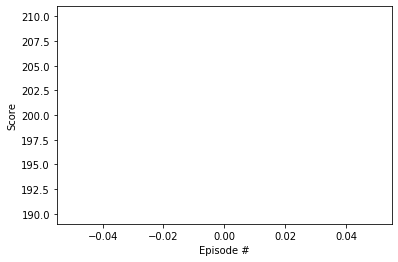

In [41]:
import time
from tqdm import tqdm
starttime=time.time()
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
n_episodes=20000
# agent=DQNAgent()

max_t=1000
eps_start=1.0
eps_end=0.2
eps_decay=0.995

eps = eps_start
env=gym.make('CartPole-v0')
eps_history=[]
best_score=-9999
eps=0
eps_end=0
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for i_ in range(1,max_t+1):
        env.render(mode = 'rgb_array')
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)
#         if reward==-100:
#             reward=-35
#         if reward==100:
#             reward=35
        agent.step(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps)
    eps_history.append(eps)
    if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Epsilon: {}'.format(i_episode, np.mean(scores_window),eps))
#             agent.policy.save("weightsfolder/policy_.h5")
    if np.mean(scores_window)>=best_score:
        best_score=np.mean(scores_window)
        print("new best_score: {}".format(best_score))
        gen_gif(agent,i_episode)
#         agent.policy.save("/anotherdrive/projects/gym/lunar/notefiles/weights/lunar_{}_.h5".format(i_episode))
    if np.mean(scores_window)>=190.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            break
endtime= time.time() 
print(endtime-starttime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [42]:
cum_reward,i_episode,reward,i_,score

(10.0, 1, 1.0, 200, 200.0)

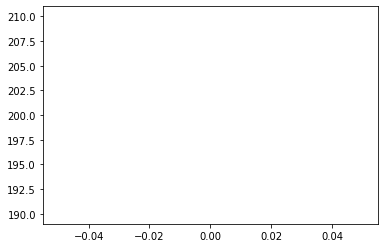

In [43]:
import pandas as pd
pd.Series(scores_window).plot()

In [44]:
eps,list(scores_window)[-5:],len(agent.memory)

(0, [200.0], 10000)

In [65]:
import matplotlib.animation as animation
def gen_video(agent,fname):


    max_t=1000

    env=gym.make('CartPole-v0')
    eps_history=[]
    eps=0
    fig=plt.figure()
    frames=[]
    state = env.reset()
    score = 0
    for i_ in range(1,max_t+1):
        frames.append([plt.imshow(env.render(mode = 'rgb_array'),animated=True)])
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)

    #     agent.step(state, action, reward, next_state, done)

        state = next_state
        score += reward
#         print(reward,reward)
        if done:
            if (reward==0):
                break 

    endtime= time.time() 

    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True,
                                repeat_delay=0)

    ani.save('/anotherdrive/projects/gym/lunar/dqnote/cart/{}_pole.gif'.format(fname),writer="PillowWriter")
    plt.close()
    print(score)
    pass

gen_video(agent,"test")

/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


247.0


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 66        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4)]               0         
________________________________________

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


11.0
new best_score: 29.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


18.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 10	Average Score: 18.90 Epsilon: 0.9511101304657719
Episode 20	Average Score: 22.85 Epsilon: 0.9046104802746175
Episode 30	Average Score: 24.57 Epsilon: 0.8603841919146962
Episode 40	Average Score: 23.73 Epsilon: 0.8183201210226743
Episode 50	Average Score: 24.94 Epsilon: 0.778312557068642
new best_score: 30.54237288135593


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


213.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 60	Average Score: 30.70 Epsilon: 0.7402609576967045
new best_score: 30.7


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


217.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 31.442622950819672


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


160.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 32.46774193548387


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


177.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 33.078125


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


325.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 33.333333333333336


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


258.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 70	Average Score: 33.56 Epsilon: 0.7040696960536299
new best_score: 33.55714285714286


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


189.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 34.84722222222222


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


367.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 35.432432432432435


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


182.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 36.6


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


298.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 36.60526315789474


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


178.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 36.93589743589744


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


165.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 80	Average Score: 36.99 Epsilon: 0.6696478204705644
new best_score: 36.9875


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


165.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 38.02469135802469


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


443.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 38.207317073170735


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


226.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 38.38095238095238


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


293.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 38.752941176470586


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


222.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 39.05747126436781


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


170.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 39.39772727272727


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


211.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 90	Average Score: 40.11 Epsilon: 0.6369088258938781
new best_score: 40.111111111111114


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


221.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 40.20879120879121


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


198.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 41.10752688172043


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


417.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 41.6875


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


489.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 43.08247422680412


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


295.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 44.66326530612245


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


286.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 44.82 Epsilon: 0.6057704364907278
new best_score: 44.82


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


187.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 44.99


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


191.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 45.69


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


279.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 46.14


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


317.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 46.59


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


268.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 47.21


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


247.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 47.64


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


291.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 47.72


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


218.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 47.79


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


251.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 110	Average Score: 48.22 Epsilon: 0.5761543988830038
new best_score: 48.22


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


433.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 48.29


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


272.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 49.0


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


346.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 50.27


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


383.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 50.73


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


553.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 51.2


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


200.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 52.63


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


259.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 52.79


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


254.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 53.68


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


191.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 120	Average Score: 55.27 Epsilon: 0.547986285490042
new best_score: 55.27


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


278.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 56.22


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


391.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 58.1


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


230.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 59.19


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


233.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 59.99


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


357.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 60.18


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


254.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 62.23


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


422.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 64.76


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


257.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 65.4


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


432.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 66.51


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


319.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 130	Average Score: 66.14 Epsilon: 0.5211953074858876
new best_score: 67.81


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


277.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 69.83


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


302.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 71.28


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


216.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 71.81


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


296.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 72.04


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


335.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 72.41


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


548.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 72.89


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


248.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 74.56


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


420.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 76.65


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


277.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 140	Average Score: 77.78 Epsilon: 0.49571413690105054
new best_score: 77.78


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


241.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 78.87


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


257.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 80.36


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


329.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 82.17


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


256.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 82.94


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


299.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 84.03


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


591.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 86.07


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


367.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 86.44


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


211.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 150	Average Score: 87.52 Epsilon: 0.47147873742168567
new best_score: 87.52


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


234.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 90.14


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


568.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 92.08


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


359.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 92.94


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


344.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 94.26


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


244.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 95.24


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


198.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 96.27


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


541.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 97.81


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


264.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 98.51


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


267.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 98.94


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


245.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 160	Average Score: 100.46 Epsilon: 0.4484282034609769
new best_score: 100.46


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


505.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 100.77


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


260.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 102.34


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


655.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 102.52


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


417.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 103.86


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


352.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 105.13


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


346.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 107.49


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


235.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 109.04


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


181.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 170	Average Score: 109.51 Epsilon: 0.42650460709830135
new best_score: 109.51


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


183.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 111.14


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


364.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 112.75


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


306.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 114.96


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


275.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 115.77


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


666.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 116.03


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


299.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 117.3


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


468.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 117.89


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


228.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 118.99


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


364.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 180	Average Score: 119.27 Epsilon: 0.40565285250151817
new best_score: 119.27


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


289.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 121.15


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


182.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 123.16


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


406.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 125.33


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


308.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 126.77


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


199.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 126.9


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


210.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 128.68


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


372.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 130.92


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


224.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 132.83


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


274.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 135.42


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


238.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 190	Average Score: 136.05 Epsilon: 0.3858205374665315
new best_score: 136.05


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


169.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 139.44


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


354.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 141.67


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


311.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 143.28


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


215.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 144.1


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


240.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 145.3


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


274.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 146.75


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


271.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 200	Average Score: 147.80 Epsilon: 0.3669578217261671
new best_score: 147.8


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


230.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 150.49


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


223.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 151.91


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


364.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 154.25


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


331.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 155.77


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


195.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 157.61


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


287.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 157.82


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


210.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 159.14


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


215.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 161.56


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


234.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 210	Average Score: 162.41 Epsilon: 0.34901730169741024
new best_score: 162.41


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


336.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 164.21


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


182.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 164.44


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


262.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 166.32


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


260.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 167.63


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


212.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


new best_score: 170.88


KeyboardInterrupt: 

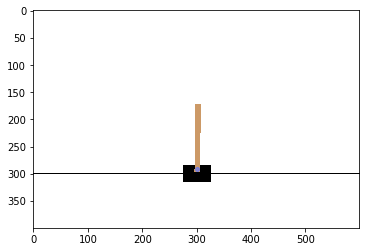

In [68]:
import time
from tqdm import tqdm
starttime=time.time()
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
n_episodes=20000
agent=DQNAgent()

max_t=1000
eps_start=1.0
eps_end=0.2
eps_decay=0.995

eps = eps_start
env=gym.make('CartPole-v0')
eps_history=[]
best_score=-9999

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for i_ in range(1,max_t):
#         env.render(mode = 'rgb_array')
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)

        agent.step(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
        if done:
            if (reward==0):
                break 
            
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps)
    eps_history.append(eps)
    if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Epsilon: {}'.format(i_episode, np.mean(scores_window),eps))
#             agent.policy.save("weightsfolder/policy_.h5")
    if np.mean(scores_window)>=best_score:
        best_score=np.mean(scores_window)
        print("new best_score: {}".format(best_score))
        gen_video(agent,i_episode)
        plt.close('all')
#         agent.policy.save("/anotherdrive/projects/gym/lunar/notefiles/weights/lunar_{}_.h5".format(i_episode))
#     if np.mean(scores_window)>=190.0:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
#             break
endtime= time.time() 
print(endtime-starttime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [71]:
eps,i_episode

(0.3403786882983606, 215)

In [ ]:
import time
from tqdm import tqdm
starttime=time.time()
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
n_episodes=2000
# agent=DQNAgent()

max_t=1000
eps_start=0.3
eps_end=0.2
eps_decay=0.995

eps = eps_start
env=gym.make('CartPole-v0')
eps_history=[]


for i_episode in range(215, n_episodes+1):
    state = env.reset()
    score = 0
    for i_ in range(1,max_t):
#         env.render(mode = 'rgb_array')
        action = agent.play(state,eps)
        next_state, reward, done, _ = env.step(action)

        agent.step(state, action, reward, next_state, done)
        
        state = next_state
        score += reward
        if done:
            if (reward==0):
                break 
            
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps)
    eps_history.append(eps)
    if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Epsilon: {}'.format(i_episode, np.mean(scores_window),eps))
#             agent.policy.save("weightsfolder/policy_.h5")
    if np.mean(scores_window)>=best_score:
        best_score=np.mean(scores_window)
        print("new best_score: {}".format(best_score))
        gen_video(agent,i_episode)
        plt.close('all')
#         agent.policy.save("/anotherdrive/projects/gym/lunar/notefiles/weights/lunar_{}_.h5".format(i_episode))
#     if np.mean(scores_window)>=190.0:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
#             break
endtime= time.time() 
print(endtime-starttime)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

new best_score: 464.0


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


303.0


/home/dhcoe/.conda/envs/gymenv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 220	Average Score: 311.67 Epsilon: 0.2911117528068797
Episode 230	Average Score: 290.44 Epsilon: 0.27687933719227076
Episode 240	Average Score: 264.62 Epsilon: 0.26334274252021705
Episode 250	Average Score: 272.78 Epsilon: 0.25046795019561774
Episode 260	Average Score: 265.59 Epsilon: 0.23822260478804844
Episode 270	Average Score: 270.84 Epsilon: 0.2265759327198568
Episode 280	Average Score: 265.73 Epsilon: 0.21549866492958691
Episode 290	Average Score: 263.79 Epsilon: 0.2049629633163791
Episode 300	Average Score: 256.00 Epsilon: 0.2
Episode 310	Average Score: 248.85 Epsilon: 0.2
Episode 320	Average Score: 240.39 Epsilon: 0.2
